In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs

from icprem.love import PREMLoveParameters
from tti.traveltimes import TravelTimeCalculator

In [2]:
R = 1221.5

In [3]:
PREM = PREMLoveParameters()
HCP_FE = PREMLoveParameters(2493, 2689, 1805, 577, -(1151 - 2493) / 2)  # Taken from https://academic.oup.com/gji/article/202/1/94/584821 table 1
ARBITRARY = PREMLoveParameters(1, 2, 3, 4, 5)

In [4]:
polar_path = np.array([[0.0, -90.0, R], [0.0, 90.0, R]])
equatorial_path_1 = np.array([[-90.0, 0.0, R], [90.0, 0.0, R]])
equatorial_path_2 = np.array([[135.0, 0.0, R], [-45.0, 0.0, R]])
diag_path = np.array([[-135.0, -45.0, R], [135.0, 45.0, R]])

ic_in = np.stack(
    [a[0] for a in [polar_path, equatorial_path_1, equatorial_path_2, diag_path]]
)
ic_out = np.stack(
    [a[1] for a in [polar_path, equatorial_path_1, equatorial_path_2, diag_path]]
)

ttc = TravelTimeCalculator(ic_in, ic_out, nested=False, shear=True, N=True)
ttc.path_directions

array([[-6.12323400e-17,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 7.07106781e-01, -7.07106781e-01,  0.00000000e+00],
       [ 5.37348558e-17,  5.77350269e-01,  8.16496581e-01]])

In [5]:
eta1 = np.linspace(-180, 180, 360)
eta2 = np.linspace(0, 90, 90)

e1, e2 = np.meshgrid(eta1, eta2, indexing="ij")
e1 = e1.flatten()
e2 = e2.flatten()

IC_MODEL: PREMLoveParameters = HCP_FE

A = np.broadcast_to(IC_MODEL.A, e1.shape)
C = np.broadcast_to(IC_MODEL.C, e1.shape)
F = np.broadcast_to(IC_MODEL.F, e1.shape)
L = np.broadcast_to(IC_MODEL.L, e1.shape)
N = np.broadcast_to(IC_MODEL.N, e1.shape)

m = np.stack([A, C, F, L, N, e1, e2], axis=1)
m.shape

(32400, 7)

In [6]:
grad = ttc.gradient(m) # (n_models, n_parameters, n_paths)
grad = grad.reshape(eta1.size, eta2.size, *grad.shape[1:]) # (n_eta1, n_eta2, n_paths, n_parameters)
grad.shape

(360, 90, 7, 4)

In [7]:
def normalise(dT: np.ndarray) -> np.ndarray:
    """Normalise dT to the range [-1, 1]."""
    dT[np.abs(dT) < 1e-10] = 0  # clip tiny values
    return dT / np.max(np.abs(dT), axis=(0, 1), keepdims=True)
    return dT


polar_n = ttc.path_directions[0]
dT_polar = normalise(grad[..., 0])

equatorial_n_1 = ttc.path_directions[1]
dT_equatorial_1 = normalise(grad[..., 1])

equatorial_n_2 = ttc.path_directions[2]
dT_equatorial_2 = normalise(grad[..., 2])

diag_n = ttc.path_directions[3]
dT_diag = normalise(grad[..., 3])

/var/folders/09/3w8zj_452w14j_351ybq0g240000gp/T/ipykernel_35281/441206202.py:4: RuntimeWarning: invalid value encountered in divide
  return dT / np.max(np.abs(dT), axis=(0, 1), keepdims=True)


In [8]:
def direction_to_lon_lat(n: np.ndarray) -> tuple[float, float]:
    """Convert a direction vector n to longitude and latitude."""
    x, y, z = n
    lon = np.arctan2(y, x)
    lat = np.arcsin(z / np.linalg.norm(n))
    return np.degrees(lon), np.degrees(lat)


polar_n_lon, polar_n_lat = direction_to_lon_lat(polar_n)
equatorial_n_1_lon, equatorial_n_1_lat = direction_to_lon_lat(equatorial_n_1)
equatorial_n_2_lon, equatorial_n_2_lat = direction_to_lon_lat(equatorial_n_2)
diag_n_lon, diag_n_lat = direction_to_lon_lat(diag_n)

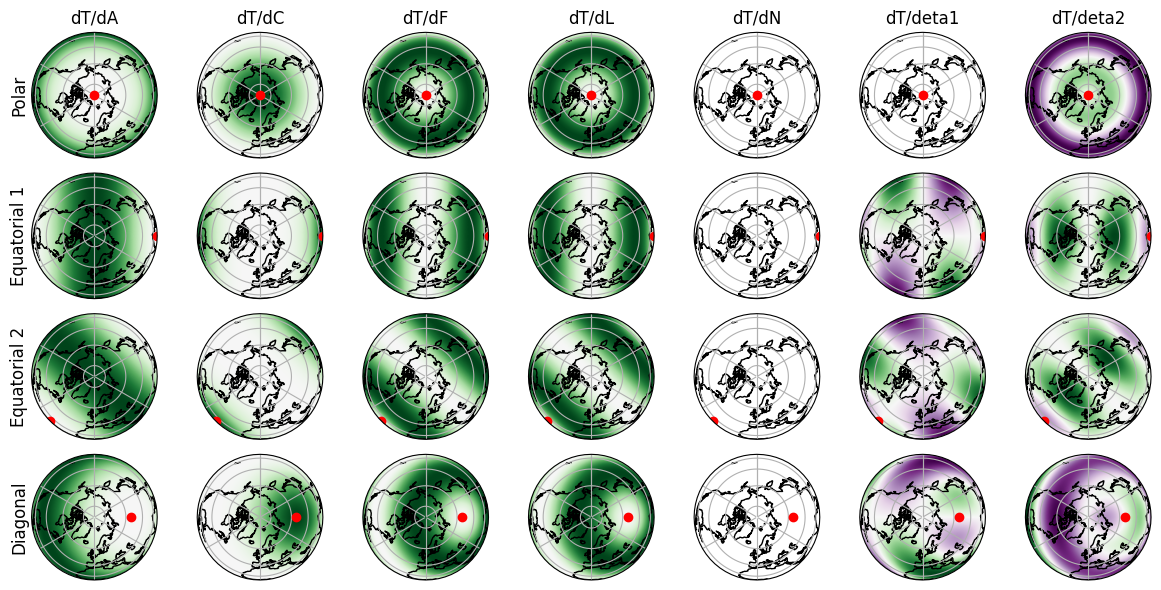

In [9]:
fig, axs = plt.subplots(
    4, 7, figsize=(12, 6), subplot_kw={"projection": ccrs.Orthographic(0, 90)}
)  # northern hemisphere orthographic projection

vmin = -1
vmax = 1

extent = [-180, 180, 0, 90]
cmap = "PRGn"
transform = ccrs.PlateCarree()

for ax in axs.flatten():
    ax.coastlines()
    ax.gridlines()

for ax_row, dT_path, path in zip(
    axs,
    [dT_polar, dT_equatorial_1, dT_equatorial_2, dT_diag],
    [
        (polar_n_lon, polar_n_lat),
        (equatorial_n_1_lon, equatorial_n_1_lat),
        (equatorial_n_2_lon, equatorial_n_2_lat),
        (diag_n_lon, diag_n_lat),
    ],
):
    for ax, dT in zip(ax_row, dT_path.transpose(2, 1, 0)): # transpose to (n_parameters, n_eta2=n_rows, n_eta1=n_columns) for correct plotting
        ax.imshow(
            dT,
            extent=extent,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            transform=transform,
        )
        ax.plot(*path, "ro", transform=transform)

for ax, label in zip(axs[0, :], ["A", "C", "F", "L", "N", "eta1", "eta2"]):
    ax.set_title(f"dT/d{label}")
for ax, label in zip(axs[:, 0], ["Polar", "Equatorial 1", "Equatorial 2", "Diagonal"]):
    ax.text(
        -0.1,
        0.5,
        label,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="center",
        horizontalalignment="center",
        rotation=90,
    )

fig.tight_layout()